In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sqlite3 as sql
import sys
import yfinance as yf

In [2]:
sys.path.append('../')

from src.db_default import DB_DIR, DB_FROZEN_VARIANTS
from src.db_class import DBCursor, FinanceDB

### Pulling data from DB

In [3]:
db_variant_label = 'v1'
db_filename = DB_FROZEN_VARIANTS['v1']['db_filename']
finance_db = FinanceDB(db_filename)

In [4]:
ticker = 'BTC-USD'
df = finance_db.get_daily_per_ticker(ticker)

In [5]:
#print(df)

### Prepare Random Forest

#### Settings

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [7]:
column_choice = 'close'
use_random_data_instead_of_database = False

assert column_choice in ['open', 'high', 'low', 'close', 'adjusted_close', 'volume']

In [8]:
seed_1 = 0  # for random data gen
seed_2 = 0  # for train test split
seed_3 = 0  # for RandomForest classifier

In [9]:
seq_size = 5

#### Prep data

In [10]:
if use_random_data_instead_of_database:
    np.random.seed(seed_1)
    raw_data = np.random.normal(loc=1, scale=0.1, size=100000)
else:
    raw_data = df[column_choice].values

# np.random.shuffle(raw_data)

In [11]:
diff = raw_data[1:] - raw_data[:-1]
frac_diff = diff / raw_data[:-1]
# frac_diff = raw_data

n_samples = len(frac_diff) // (seq_size+1)
if len(frac_diff) % (seq_size+1) != 0:
    relative_data = frac_diff[:-(len(frac_diff) % (seq_size+1))]
else:
    relative_data = frac_diff
    
relative_data = relative_data.reshape((n_samples, (seq_size+1)))

X = relative_data[:, :seq_size]
Y = np.sign(relative_data[:, -1])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=seed_2)

#### Analyze data

0.002531822838734687


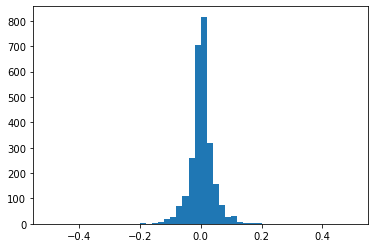

In [24]:
print(np.mean(frac_diff))

plt.hist(frac_diff, bins=np.linspace(-0.5, 0.5, 51))
plt.show()

0.1085972850678733


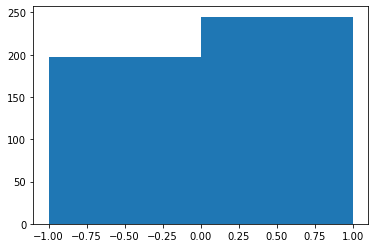

In [33]:
print(np.mean(Y))

plt.hist(Y, bins=np.linspace(-1.0, 1.0, 3))
plt.show()

#### Train classifer

In [34]:
## hyperparameters

forest_size = [10, 100, 1000, 10000]
max_depth = [1, 2, 3, 4, 5]

In [36]:
classifer = RandomForestClassifier

def train_rf(fs, md):

    myRF_clf = classifer(
            n_estimators=fs,
            max_depth=md, 
            min_samples_split=2, # minimum number of sample per leaf
            oob_score=True,
            random_state=seed_3,
            warm_start=False # this ensures that you add estimators without retraining everything
        )

    myRF_clf.fit(X_train, Y_train)

    return myRF_clf.score(X_train,Y_train), myRF_clf.oob_score_, myRF_clf.score(X_test,Y_test)

In [ ]:
test_scores = np.zeros([len(forest_size), len(max_depth)])

for i in range(len(forest_size)):
    for j in range(len(max_depth)):
        _, _, test_scores[i, j] = train_rf(forest_size[i], max_depth[j])

In [44]:
import matplotlib.colors as colors 
import matplotlib.cm as cm
import matplotlib.ticker as mticker
import matplotlib as mpl

norm = colors.Normalize(vmin=min(test_scores.flatten()), vmax=max(test_scores.flatten()))
mapper = cm.ScalarMappable(norm=norm, cmap=cm.brg)
cs = mapper.to_rgba(test_scores)

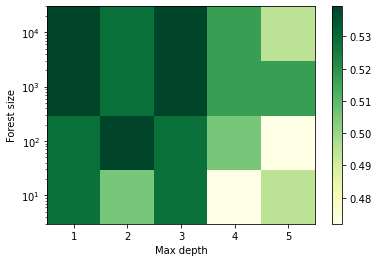

In [82]:
plt.pcolor([0.5, 1.5, 2.5, 3.5, 4.5, 5.5], [3, 30, 300, 3000, 30000], test_scores, cmap=cm.YlGn, vmin=min(test_scores.flatten()), vmax=max(test_scores.flatten()))
plt.yscale('log')
plt.xlabel("Max depth")
plt.ylabel("Forest size")
# plt.yticks([1, 2, 3, 4, 5])
plt.colorbar()